# Transfer learning for Mixed Eye Disease Fundus

## General Libraries

In [1]:
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow and Keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, model_from_json, save_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

In [2]:
# Check Tensorflow version

print('Current Tensorflow version:', tf.__version__)

Current Tensorflow version: 2.10.0


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True) # Telling tensorflow to not use up all of the GPU memory

In [4]:
# Check GPUs availability

print('Num GPUs available:', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs available: 1


In [5]:
# Check Cuda availability

print('Built with CUDA:', tf.test.is_built_with_cuda())
print('Built with GPU support:', tf.test.is_built_with_gpu_support())
print('List physical devices:\n', tf.config.list_physical_devices())
print('List logical devices:\n', tf.config.list_logical_devices())

Built with CUDA: True
Built with GPU support: True
List physical devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
List logical devices:
 [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]


## Data preparation

### Set the base directory

In [6]:
# Set the base directory

main_project_dir = 'D:/Kuliah/Proyek Akhir 2022'
main_dataset_dir = os.path.join(main_project_dir, 'Dataset')
train_dir = os.path.join(main_dataset_dir, 'Dataset (Splitted) 2/train')
test_dir = os.path.join(main_dataset_dir, 'Dataset (Splitted) 2/test')

def is_directory_exists(path):
    if os.path.exists(path):
        print(f'"{path}" directory is exist')
    else:
        print(f'"{path}" directory is not exist')

is_directory_exists(main_project_dir)
is_directory_exists(main_dataset_dir)
is_directory_exists(train_dir)
is_directory_exists(test_dir)

print('\nProject directory:', main_project_dir)
print('Main dataset directory:', main_dataset_dir)
print('Train dataset directory:', train_dir)
print('Test dataset directory:', test_dir)

"D:/Kuliah/Proyek Akhir 2022" directory is exist
"D:/Kuliah/Proyek Akhir 2022\Dataset" directory is exist
"D:/Kuliah/Proyek Akhir 2022\Dataset\Dataset (Splitted) 2/train" directory is exist
"D:/Kuliah/Proyek Akhir 2022\Dataset\Dataset (Splitted) 2/test" directory is exist

Project directory: D:/Kuliah/Proyek Akhir 2022
Main dataset directory: D:/Kuliah/Proyek Akhir 2022\Dataset
Train dataset directory: D:/Kuliah/Proyek Akhir 2022\Dataset\Dataset (Splitted) 2/train
Test dataset directory: D:/Kuliah/Proyek Akhir 2022\Dataset\Dataset (Splitted) 2/test


In [7]:
os.getcwd()

'd:\\Kuliah\\Proyek Akhir 2022\\eye-disease-classification-app\\deep-learning-model'

## Data loading & augmentation

### Set some training parameters

In [8]:
# Set some training hyperparameters

BATCH_SIZE = 32

IMG_SIZE_1 = 32
IMG_SIZE_2 = 64
IMG_SIZE_3 = 100
IMG_SIZE_4 = 128
IMG_SIZE_5 = 180
IMG_SIZE_6 = 224
IMG_SIZE_7 = 256
IMG_SIZE = (IMG_SIZE_3, IMG_SIZE_3)

print('BATCH_SIZE:', BATCH_SIZE)
print('IMG_SIZE:', IMG_SIZE, '| IMG_SIZE type:', type(IMG_SIZE))

BATCH_SIZE: 32
IMG_SIZE: (100, 100) | IMG_SIZE type: <class 'tuple'>


### Load the dataset

In [9]:
# Import the preprocessing input function from the model to be used

from tensorflow.keras.applications.resnet import preprocess_input

In [10]:
# Create the datagen for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

datagen = {
    'train': ImageDataGenerator(
        vertical_flip=True,
        horizontal_flip=True,
        rotation_range=20,
        fill_mode='constant',
        preprocessing_function=preprocess_input

    ),
    'test': ImageDataGenerator(
        preprocessing_function=preprocess_input
    ),
}

In [11]:
# Create the image generator for each dataset using ImageDataGenerator (this library is deprecated since TF 2.10)

test_image_source = 'mixed_test_images/Cataract.jpg'
augmentation_dest_path = 'mixed_augmentations_examples'

data_sets = {
    'train': datagen['train'].flow_from_directory(
        train_dir, 
        shuffle=True, 
        seed=42, 
        class_mode='sparse', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE,

        # Uncomment these lines if we want to preview and save some augmented images
        # save_to_dir=augmentation_dest_path,
        # save_prefix='aug',
        # save_format='png'
    ),
    'test': datagen['test'].flow_from_directory(
        test_dir, 
        shuffle=False, 
        class_mode='sparse', 
        batch_size=BATCH_SIZE, 
        target_size=IMG_SIZE
    )
}

Found 4224 images belonging to 4 classes.
Found 88 images belonging to 4 classes.


In [12]:
# Get the list of class names (assuming each class has its own folder in the dataset directory)
class_names = sorted(os.listdir(train_dir))

# Initialize empty lists to store the input data (images) and target data (labels)
images = []
labels = []

# Loop through the class folders
for class_name in class_names:
    class_dir = os.path.join(train_dir, class_name)
    
    # Loop through the image files in each class folder
    for image_file in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_file)
        
        # Load and preprocess the image
        image = tf.keras.preprocessing.image.load_img(image_path, target_size=(100, 100))
        image = tf.keras.preprocessing.image.img_to_array(image)
        
        # Append the preprocessed image to the input data list
        images.append(image)
        
        # Append the class index to the target data list
        labels.append(class_names.index(class_name))

# Convert the input data list to a NumPy array
images = np.array(images)

# Convert the target data list to a NumPy array
labels = np.array(labels)

### Preview the image dataset

In [13]:
def show_images_from_dataset(dataset_type):
    if dataset_type not in ['train', 'test']:
        raise ValueError("Invalid dataset_type. Choose 'train', or 'test'.")

    # Get a batch of images and their labels
    images, labels = next(data_sets[dataset_type])

    # Configure the figure for plotting
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()

    # Plot each image with its corresponding label
    for img, label, ax in zip(images, labels, axes):

        # Use this below code if you must converts image from [-1,1] to [0,255]
        # img_array = image.img_to_array(img)
        # norm_img = cv.normalize(img, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        # ax.imshow(norm_img.astype('uint8'))

        ax.imshow(img.astype('uint8'))
        ax.set_title(f"Class: {class_names[int(label)]}")
        ax.axis('on')
    
    if dataset_type == 'train':
        plt.suptitle('Preprocessed/Augmented Train Images')
    elif dataset_type == 'test':
        plt.suptitle('Preprocessed/Augmented Test Images')

    # Show the plot
    plt.tight_layout()
    plt.show()

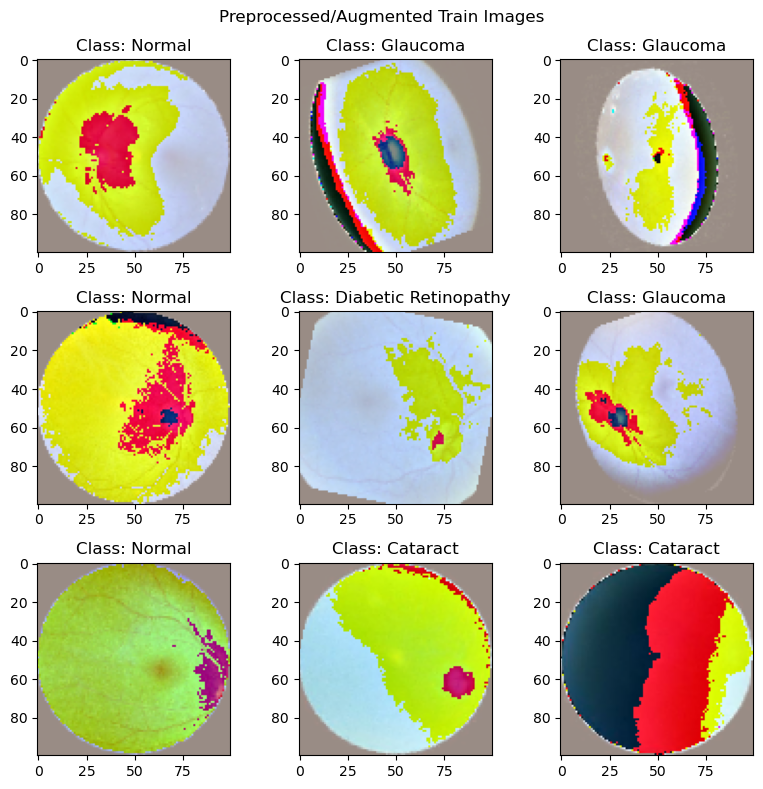

In [14]:
# Check and show images from training data generator

show_images_from_dataset('train')

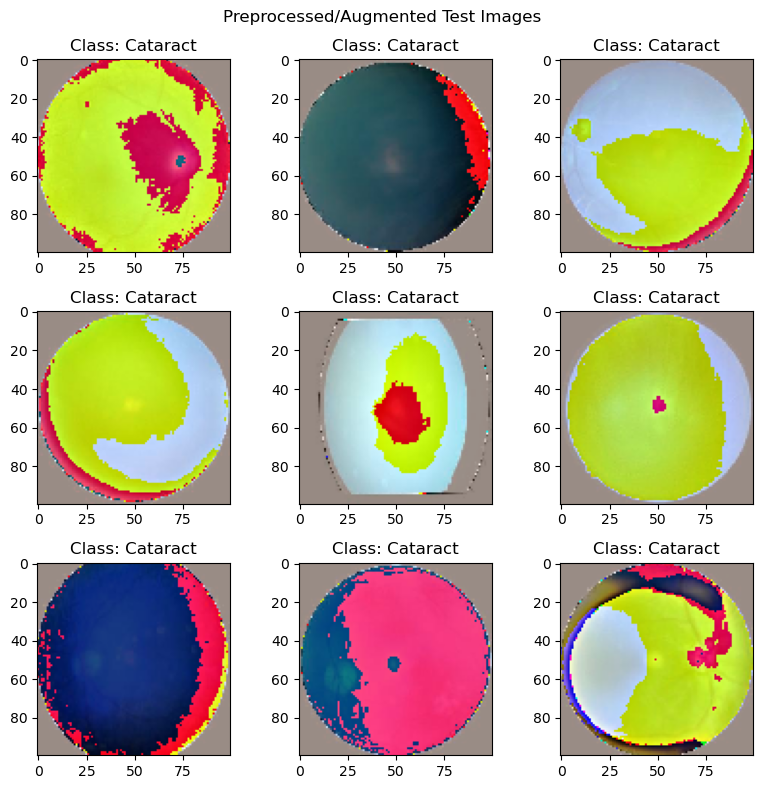

In [15]:
# Check and show images from test data generator

show_images_from_dataset('test')

## Feature extraction

In [16]:
# Define the K in StratifiedKFold

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True)

In [17]:
# Set some training hyperparameters

IMG_SHAPE = IMG_SIZE + (3,)
BASE_LR = 0.0001
INIT_EPOCH = 30
FINE_TUNE_EPOCHS = 10

In [18]:
# Create empty lists to store the training history and test accuracies and losses

training_histories = []
finetune_histories = []
test_accuracies = []
test_losses = []

In [19]:
# Create a function that plots training learning curves

def plot_training_learning_curves(history, index):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title(f'Training and Validation Accuracy in K-{index + 1}')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title(f'Training and Validation Loss in K-{index + 1}')
    plt.xlabel('epoch')
    plt.show()

In [20]:
# Create a function that plots finetuning training learning curves

def plot_finetuning_training_learning_curves(history_fine, index):
    acc = history_fine.history['accuracy']
    val_acc = history_fine.history['val_accuracy']

    loss = history_fine.history['loss']
    val_loss = history_fine.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.8, 1])
    plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
            plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title(f'Fine Tuned Training and Validation Accuracy in K-{index + 1}')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.plot([INIT_EPOCH-1,INIT_EPOCH-1],
            plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title(f'Fine Tuned Training and Validation Loss in K-{index + 1}')
    plt.xlabel('epoch')
    plt.show()

In [21]:
print(images.shape)
print(labels.shape)

(4224, 100, 100, 3)
(4224,)


### Perform training with KFold cross validation 

In [22]:
from tensorflow.keras.applications import ResNet50 

In [23]:
# Build the whole CNN model with KFold splitting

i = 1

for train_index, val_index in skf.split(images, labels):
    train_data = images[train_index]
    train_labels = labels[train_index]

    val_data = images[val_index]
    val_labels = labels[val_index]

    # Define some callbacks
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        os.path.join('trained_model', f'resnet50_mixed_best_model_with_kfold_{i}.h5'),
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    # Create the base model
    base_model = ResNet50(
        input_shape=IMG_SHAPE,
        include_top=False,
        weights='imagenet'
    )

    # Freeze the trainable layers
    base_model.trainable = False

    # Create the whole model with some additional top layers
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(4, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        train_data,
        train_labels,
        epochs=INIT_EPOCH,
        validation_data=(val_data, val_labels),
        callbacks=[model_checkpoint]
    )

    # Append history in the history list
    training_histories.append(history)

    print('\n===============================================================================\n')

    # FINE TUNING PART

    fine_tune_at = 100

    # base_model.trainable = True
    # for layer in base_model.layers[:fine_tune_at]:
    #     layer.trainable = False

    for layer in model.layers[:fine_tune_at]:
        layer.trainable = False
    for layer in model.layers[fine_tune_at:]:
        layer.trainable = True

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=BASE_LR/10),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    TOTAL_EPOCHS =  INIT_EPOCH + FINE_TUNE_EPOCHS

    history_fine = model.fit(
        train_data,
        train_labels,
        epochs=TOTAL_EPOCHS,
        initial_epoch=history.epoch[-1],
        validation_data=(val_data, val_labels),
        callbacks=[model_checkpoint]
    )

    # Append finetune history in the history list
    finetune_histories.append(history_fine)

    print('\n===============================================================================\n')

    loss, accuracy = model.evaluate(data_sets['test'])

    print("Test loss: {:.2f}".format(loss))
    print("Test accuracy: {:.2f}".format(accuracy))

    test_accuracies.append(accuracy)
    test_losses.append(loss)

    i += 1

Epoch 1/30
106/106 [==============================] - ETA: 0s - loss: 0.5623 - accuracy: 0.7866
Epoch 1: val_loss improved from inf to 0.34752, saving model to trained_model\resnet50_mixed_best_model_with_kfold_1.h5
106/106 [==============================] - 38s 222ms/step - loss: 0.5623 - accuracy: 0.7866 - val_loss: 0.3475 - val_accuracy: 0.8675
Epoch 2/30
106/106 [==============================] - ETA: 0s - loss: 0.3007 - accuracy: 0.8905
Epoch 2: val_loss improved from 0.34752 to 0.29888, saving model to trained_model\resnet50_mixed_best_model_with_kfold_1.h5
106/106 [==============================] - 22s 203ms/step - loss: 0.3007 - accuracy: 0.8905 - val_loss: 0.2989 - val_accuracy: 0.8876
Epoch 3/30
106/106 [==============================] - ETA: 0s - loss: 0.2257 - accuracy: 0.9204
Epoch 3: val_loss improved from 0.29888 to 0.26749, saving model to trained_model\resnet50_mixed_best_model_with_kfold_1.h5
106/106 [==============================] - 22s 211ms/step - loss: 0.2257 - a

ResourceExhaustedError: Graph execution error:

Detected at node 'sequential/resnet50/conv2_block3_3_bn/FusedBatchNormV3' defined at (most recent call last):
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\ipykernel\kernelapp.py", line 725, in start
      self.io_loop.start()
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\ipykernel\kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\ipykernel\kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\ipykernel\kernelbase.py", line 409, in dispatch_shell
      await result
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\ipykernel\kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\ipykernel\zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\IPython\core\interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\IPython\core\interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\IPython\core\interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\IPython\core\interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\IPython\core\interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ASUS\AppData\Local\Temp\ipykernel_18940\1168056463.py", line 82, in <module>
      history_fine = model.fit(
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\training.py", line 993, in train_step
      y_pred = self(x, training=True)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\sequential.py", line 410, in call
      return super().call(inputs, training=training, mask=mask)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\training.py", line 557, in __call__
      return super().__call__(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\functional.py", line 510, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\functional.py", line 667, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\engine\base_layer.py", line 1097, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 850, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 660, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\utils\control_flow_util.py", line 108, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "d:\Application\Anaconda3\envs\tf-gpu-2\lib\site-packages\keras\layers\normalization\batch_normalization.py", line 649, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'sequential/resnet50/conv2_block3_3_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[32,256,25,25] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node sequential/resnet50/conv2_block3_3_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_38342]

### Learning curves

In [ ]:
# Test Accuracies & Losses

print('Test accuracies:', test_accuracies)
print('The best accuracy is', np.max(test_accuracies), f'with K-{np.argmax(test_accuracies)+1}')

print('\nTest losses:', test_losses)
print('The minimum loss is', np.min(test_losses), f'with K-{np.argmin(test_losses)+1}')

Test accuracies: [0.5340909361839294, 0.5340909361839294]
The best accuracy is 0.5340909361839294 with K-1

Test losses: [1.1378509998321533, 1.154294490814209]
The minimum loss is 1.1378509998321533 with K-1


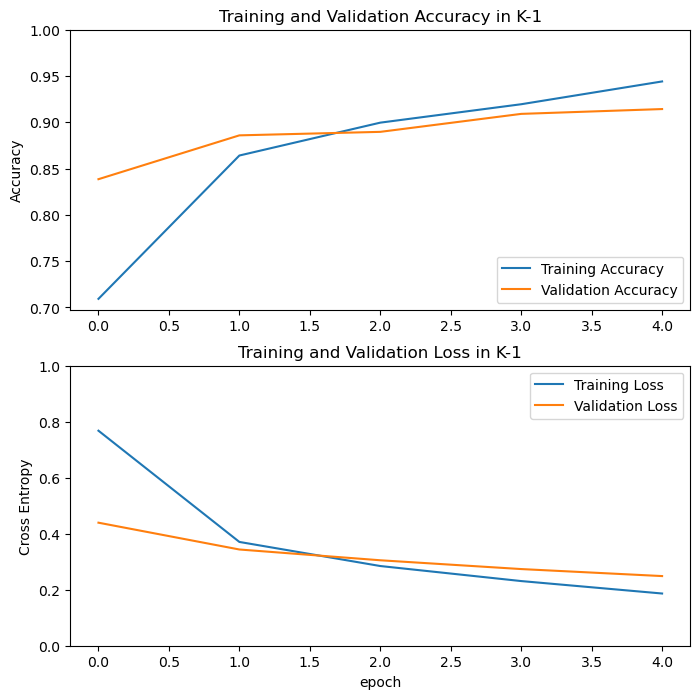

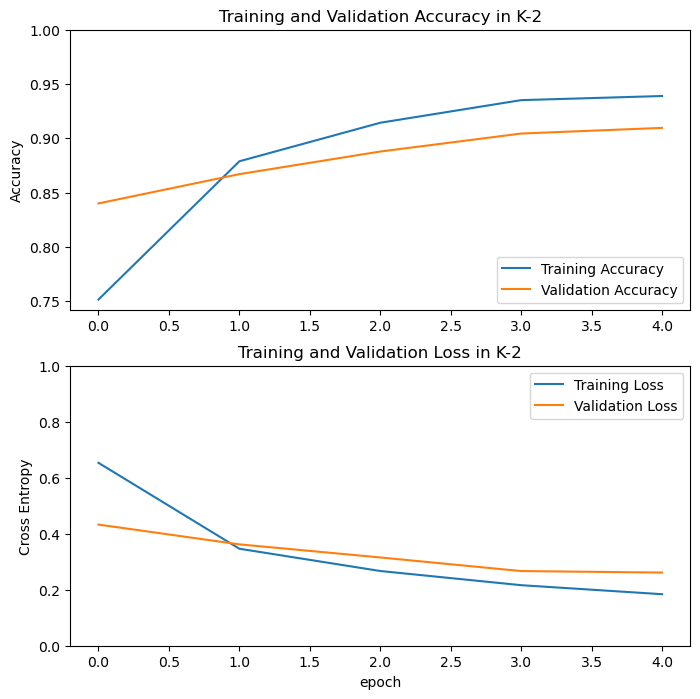

In [ ]:
for index, training in enumerate(training_histories):
    plot_training_learning_curves(training, index)

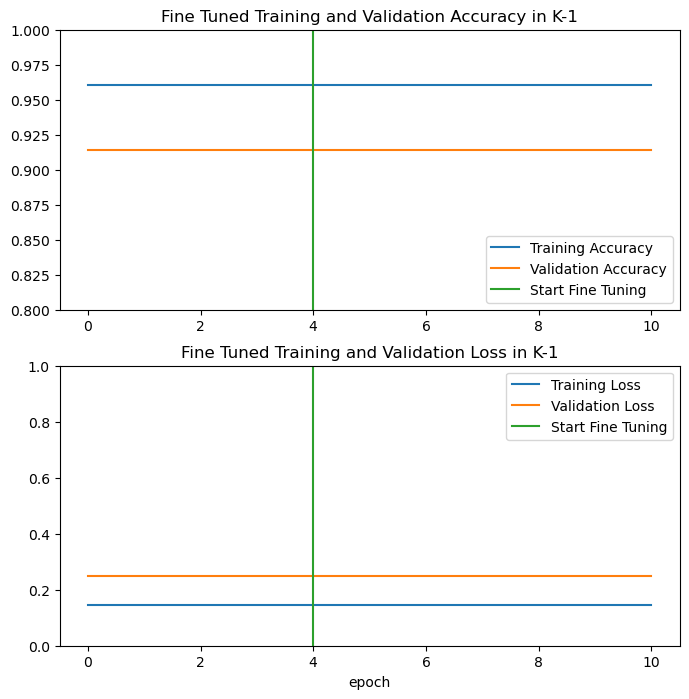

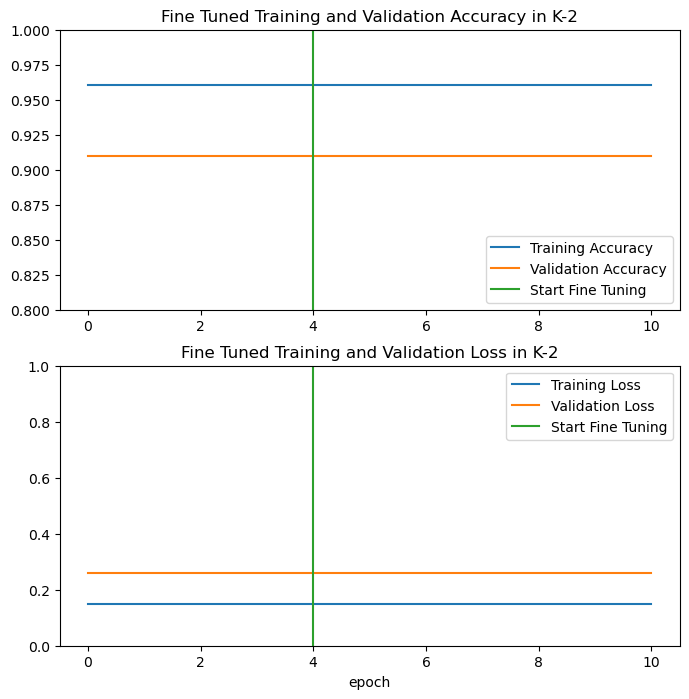

In [ ]:
for index, finetune in enumerate(finetune_histories):
    plot_finetuning_training_learning_curves(finetune, index)

## Prediction on test dataset

In [ ]:
# Do a prediction on test dataset
prediction_results = model.predict(data_sets['test'])
print('prediction_results:', prediction_results)
print('prediction_results len:', len(prediction_results))

# Find prediction ids
predicted_id = tf.math.argmax(prediction_results, axis=1)
print('predicted_id:', predicted_id)
print('predicted_id len:', len(predicted_id))

# Show dataset class names
class_names = np.array(class_names)
print('class_names:', class_names)

# Converts prediction ids into class names
predicted_label_batch = class_names[predicted_id]
print('predicted_label_batch:', predicted_label_batch)

predictions_df = pd.DataFrame(prediction_results)

3/3 [==============================] - 3s 492ms/step
prediction_results: [[3.29434872e-03 2.20490441e-01 3.92249167e-01 3.83966029e-01]
 [4.89659160e-02 9.22052026e-01 7.03959120e-03 2.19424367e-02]
 [2.09782366e-02 1.09893307e-01 2.30676848e-02 8.46060753e-01]
 [6.96582377e-01 2.35598475e-01 3.53313535e-02 3.24877538e-02]
 [6.26951754e-01 2.25854814e-01 1.02472253e-01 4.47211787e-02]
 [4.63640779e-01 2.33252600e-01 6.02241233e-02 2.42882520e-01]
 [1.17948644e-01 2.30409771e-01 7.60566723e-03 6.44035935e-01]
 [5.20005882e-01 5.40278517e-02 9.05235335e-02 3.35442752e-01]
 [1.37449861e-01 3.72430950e-01 2.12906584e-01 2.77212530e-01]
 [8.96270350e-02 2.67934799e-01 6.34116679e-02 5.79026520e-01]
 [2.62598842e-01 2.96066105e-02 6.61526978e-01 4.62676100e-02]
 [7.73944557e-02 9.90387704e-03 9.05746639e-01 6.95497915e-03]
 [1.38437063e-01 1.68974567e-02 8.25230300e-01 1.94352046e-02]
 [1.54777884e-01 1.38312072e-01 6.56171918e-01 5.07380813e-02]
 [1.76688254e-01 3.89487110e-02 7.68453836e-0

In [ ]:
predictions_df

,0,1,2,3
0,0.003294,0.220490,0.392249,0.383966
1,0.048966,0.922052,0.007040,0.021942
2,0.020978,0.109893,0.023068,0.846061
3,0.696582,0.235598,0.035331,0.032488
4,0.626952,0.225855,0.102472,0.044721
...,...,...,...,...
83,0.000116,0.761171,0.002841,0.235872
84,0.001383,0.742369,0.002586,0.253661
85,0.000330,0.792241,0.046382,0.161047
86,0.000344,0.081121,0.008349,0.910186


In [ ]:
# Add y_pred into predictions_df

predictions_df['y_pred'] = predicted_id
predictions_df

,0,1,2,3,y_pred
0,0.003294,0.220490,0.392249,0.383966,2
1,0.048966,0.922052,0.007040,0.021942,1
2,0.020978,0.109893,0.023068,0.846061,3
3,0.696582,0.235598,0.035331,0.032488,0
4,0.626952,0.225855,0.102472,0.044721,0
...,...,...,...,...,...
83,0.000116,0.761171,0.002841,0.235872,1
84,0.001383,0.742369,0.002586,0.253661,1
85,0.000330,0.792241,0.046382,0.161047,1
86,0.000344,0.081121,0.008349,0.910186,3


In [ ]:
# Add y_true into predictions_df

predictions_df['y_true'] = data_sets['test'].classes
predictions_df

,0,1,2,3,y_pred,y_true
0,0.003294,0.220490,0.392249,0.383966,2,0
1,0.048966,0.922052,0.007040,0.021942,1,0
2,0.020978,0.109893,0.023068,0.846061,3,0
3,0.696582,0.235598,0.035331,0.032488,0,0
4,0.626952,0.225855,0.102472,0.044721,0,0
...,...,...,...,...,...,...
83,0.000116,0.761171,0.002841,0.235872,1,3
84,0.001383,0.742369,0.002586,0.253661,1,3
85,0.000330,0.792241,0.046382,0.161047,1,3
86,0.000344,0.081121,0.008349,0.910186,3,3


In [ ]:
# Rename all the column headers

predictions_df.columns = [class_names[0], class_names[1], class_names[2], class_names[3], 'y_pred', 'y_true']
predictions_df

,Cataract,DR,Glaucoma,Normal,y_pred,y_true
0,0.003294,0.220490,0.392249,0.383966,2,0
1,0.048966,0.922052,0.007040,0.021942,1,0
2,0.020978,0.109893,0.023068,0.846061,3,0
3,0.696582,0.235598,0.035331,0.032488,0,0
4,0.626952,0.225855,0.102472,0.044721,0,0
...,...,...,...,...,...,...
83,0.000116,0.761171,0.002841,0.235872,1,3
84,0.001383,0.742369,0.002586,0.253661,1,3
85,0.000330,0.792241,0.046382,0.161047,1,3
86,0.000344,0.081121,0.008349,0.910186,3,3


In [ ]:
# Converts y_pred into numpy array

y_pred_in_numpy = np.array(predictions_df['y_pred'])
y_pred_in_numpy

array([2, 1, 3, 0, 0, 0, 3, 0, 1, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 3, 3, 2, 1, 3, 2, 2, 2, 2, 1, 3, 2, 2, 2, 2, 3, 2, 2, 2, 2, 1,
       3, 1, 1, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1],
      dtype=int64)

In [ ]:
# Converts y_true into numpy array

y_true_in_numpy = np.array(predictions_df['y_true'])
y_true_in_numpy

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
# Create function to generate CSV file based on dataset directory

def create_csv_file_from_dataset(filename, path, headers, dataset_source, dataset_type=''):
    supported_extensions = ['.png', '.jpg', '.jpeg']
    file_path = os.path.join(path, filename)

    try:
        with open(file_path, 'w', newline='') as csv_file:
            writer = csv.writer(csv_file)
            writer.writerow(headers)
        
        for root, dirs, files in os.walk(dataset_source + '/' + dataset_type):
            for file in files:
                if any(file.lower().endswith(ext) for ext in supported_extensions):
                    image_path = os.path.join(root, file)
                    label = os.path.basename(root)
                    with open(file_path, 'a', newline='') as csv_file:
                        writer = csv.writer(csv_file)
                        writer.writerow([file, label])
        
        print('Generating CSV file is completed.')
    except (FileNotFoundError, PermissionError) as e:
        print(f'An error occured: {e}')
    finally:
        csv_file.close()
    
    print(f'CSV file successfully created in "{file_path}"')

In [ ]:
# Create the mixed splitted dataset CSV

csv_file_name = 'test_mixed_splitted_dataset.csv'
csv_path = main_dataset_dir
dataset_source = os.path.join(main_dataset_dir, 'Dataset (Splitted) 2')
headers = ['Image', 'Label']

create_csv_file_from_dataset(csv_file_name, csv_path, headers, dataset_source, dataset_type='test')

Generating CSV file is completed.
CSV file successfully created in "D:/2110191048\Dataset\test_mixed_splitted_dataset.csv"


In [ ]:
# Load and preview the CSV dataset file

test_mixed_df = pd.read_csv(os.path.join(main_dataset_dir, csv_file_name))
test_mixed_df

,Image,Label
0,mixed - 10 - cataract (11).jpg,Cataract
1,mixed - 10 - cataract (112).jpg,Cataract
2,mixed - 10 - cataract (119).jpg,Cataract
3,mixed - 10 - cataract (122).jpg,Cataract
4,mixed - 10 - cataract (224).jpg,Cataract
...,...,...
83,mixed - 10 - normal (547).jpg,Normal
84,mixed - 10 - normal (808).jpg,Normal
85,mixed - 10 - normal (812).jpg,Normal
86,mixed - 10 - normal (862).jpg,Normal


In [ ]:
# Create function to plot dataset count in each class

def plot_dataset(dataset_df, title, figsize=(7, 6)):
    category_counts = dataset_df['Label'].value_counts()

    plt.figure(figsize=figsize)
    ax = category_counts.plot(kind='bar')
    plt.xlabel('Classes')
    plt.ylabel('Count')
    plt.title(title)

    for i, count in enumerate(category_counts):
        plt.text(i, count, str(count), ha='center', va='bottom')

    plt.setp(ax.get_xticklabels(), rotation=0)
    plt.tight_layout()
    plt.show()

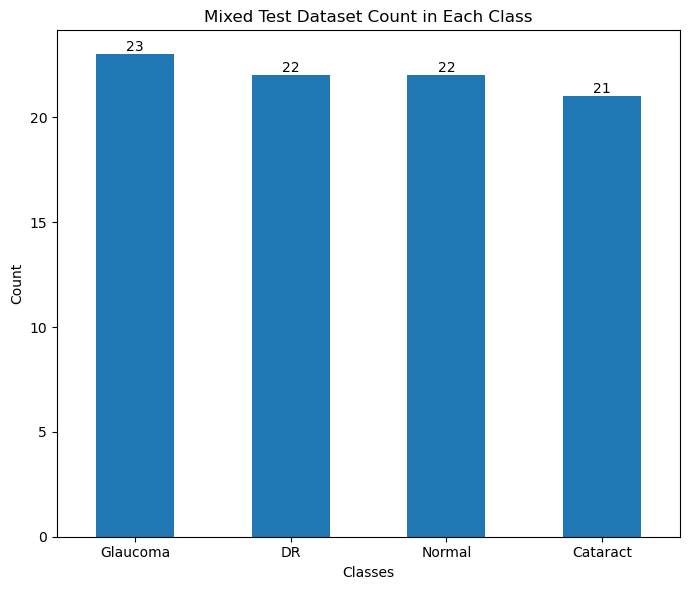

In [ ]:
# Plotting the dataset count in each class

plot_title = 'Mixed Test Dataset Count in Each Class'
plot_dataset(test_mixed_df, plot_title)

In [ ]:
# Preview predicted results for some images in test dataset

cataract_test_path = f'{test_dir}\\Cataract\\'
dr_test_path = f'{test_dir}\\DR\\'
glaucoma_test_path = f'{test_dir}\\Glaucoma\\'
normal_test_path = f'{test_dir}\\Normal\\'

def show_predicted_results(dataset_df):
    sample_test = dataset_df.head(18)
    sample_test.head()
    class_indices = data_sets['test'].class_indices
    plt.figure(figsize=(12, 24))

    for index, row in sample_test.iterrows():
        filename = row['Image']
        category = row['Label']
        y_pred = predictions_df['y_pred'][index]
        classes = list(filter(lambda x: class_indices[x] == y_pred, class_indices))[0]
        img = load_img(cataract_test_path + filename, target_size=IMG_SIZE)
        plt.subplot(6, 3, index+1)      
        plt.imshow(img)
        plt.xlabel(filename + f" ({category})\n is predicted as {classes}")

    plt.suptitle(f'Preview Some Predicted Results on Test Dataset')
    plt.tight_layout()
    plt.show()

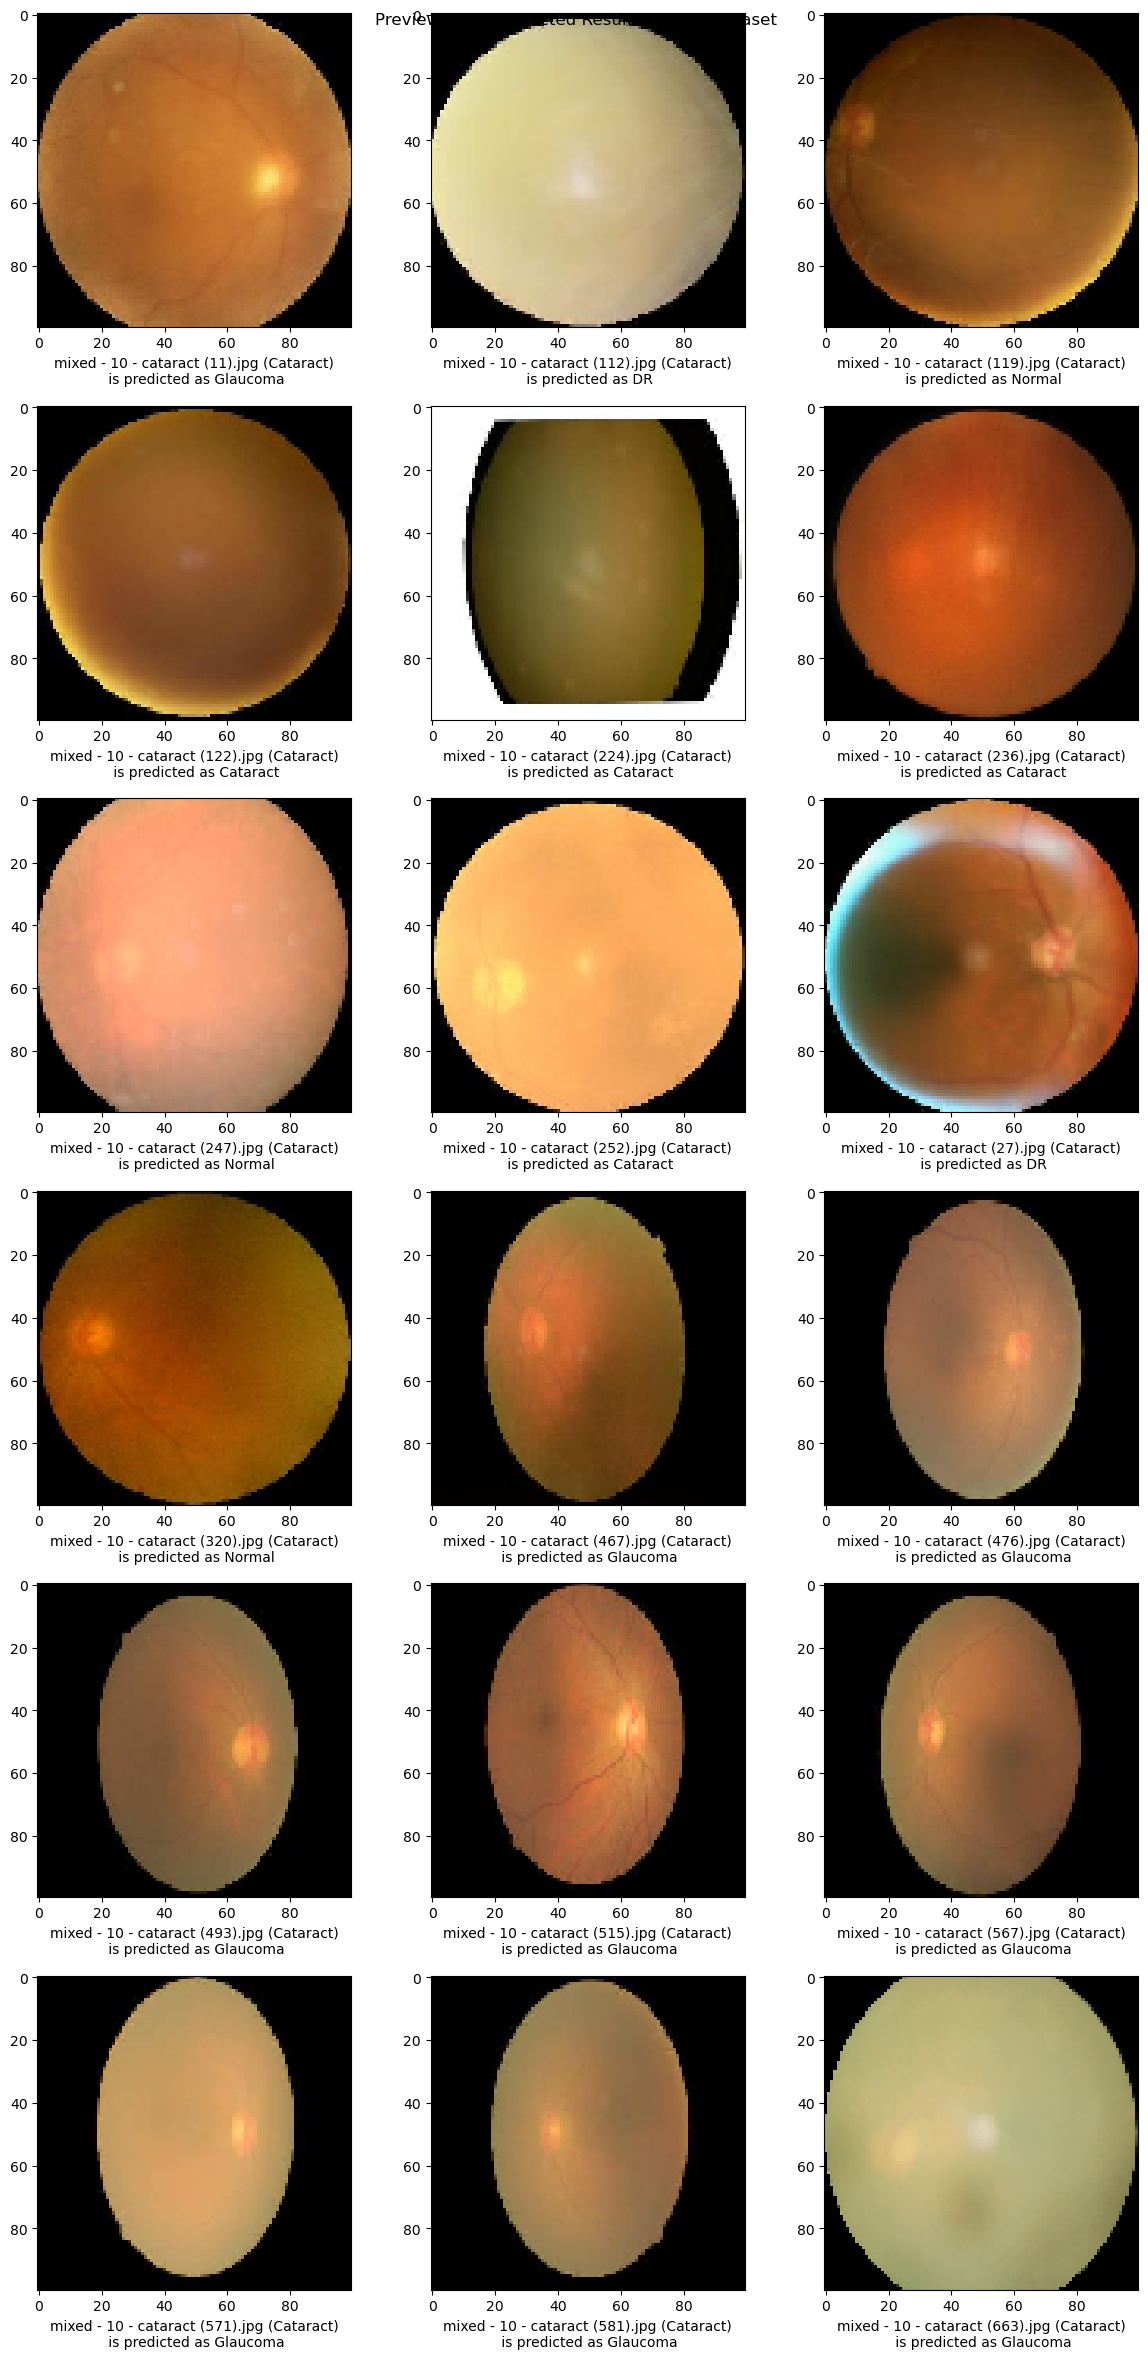

In [ ]:
# Preview some predicted results in test dataset

show_predicted_results(test_mixed_df)

## Evaluation metrics

### Classification reports

In [ ]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true_in_numpy, y_pred_in_numpy)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))
print('Weighted F1-score: {:.2f}\n'.format(f1_score(y_true_in_numpy, y_pred_in_numpy, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true_in_numpy, y_pred_in_numpy, target_names=class_names))


Accuracy: 0.53

Micro Precision: 0.53
Micro Recall: 0.53
Micro F1-score: 0.53

Macro Precision: 0.62
Macro Recall: 0.53
Macro F1-score: 0.50

Weighted Precision: 0.62
Weighted Recall: 0.53
Weighted F1-score: 0.50


Classification Report

              precision    recall  f1-score   support

    Cataract       1.00      0.24      0.38        21
          DR       0.50      0.95      0.66        22
    Glaucoma       0.62      0.65      0.64        23
      Normal       0.35      0.27      0.31        22

    accuracy                           0.53        88
   macro avg       0.62      0.53      0.50        88
weighted avg       0.62      0.53      0.50        88



### Confusion matrix

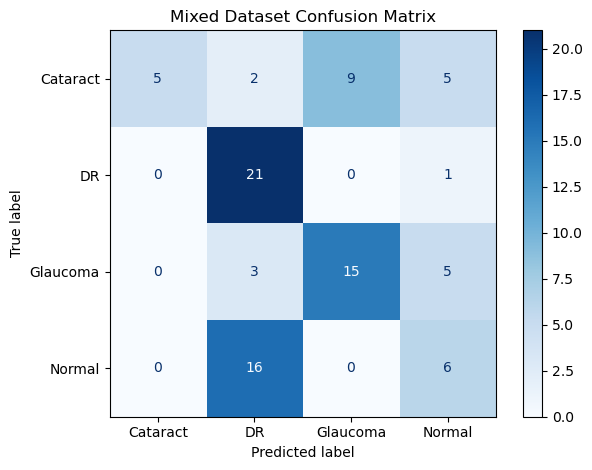

In [ ]:
# Plot the confusion matrix

cm = confusion_matrix(y_true_in_numpy, y_pred_in_numpy)

# Create labels for the matrix
labels = list(data_sets['test'].class_indices.keys())

# Plot the confusion matrix
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmap = plt.colormaps['Blues']
cmd.plot(cmap=cmap, colorbar=True)
plt.title('Mixed Dataset Confusion Matrix')
plt.tight_layout()
plt.show()